In [8]:
import urllib.request
import json
import pandas as pd
import matplotlib.pyplot as plt
from pykrx import stock
from datetime import datetime

def fetch_naver_datalab_trends(client_id, client_secret, keywords, start_date, end_date, device="pc"):
    """
    네이버 데이터랩 검색 트렌드 API 호출 및 데이터프레임 반환
    
    Parameters:
    - client_id, client_secret: 네이버 API 인증키
    - keywords: 리스트, 검색할 키워드 그룹명 및 키워드 (ex: ["상지건설"])
    - start_date, end_date: "YYYY-MM-DD" 문자열
    - device: "pc" or "mo" (default: "pc")
    
    Returns:
    - pandas DataFrame: 날짜 인덱스, 키워드별 검색 비율 데이터
    """
    url = "https://openapi.naver.com/v1/datalab/search"
    body = {
        "startDate": start_date,
        "endDate": end_date,
        "timeUnit": "date",
        "keywordGroups": [
            {
                "groupName": keywords[0],
                "keywords": keywords
            }
        ],
        "device": device
    }

    request = urllib.request.Request(url)
    request.add_header("X-Naver-Client-Id", client_id)
    request.add_header("X-Naver-Client-Secret", client_secret)
    request.add_header("Content-Type", "application/json")

    try:
        response = urllib.request.urlopen(request, data=json.dumps(body).encode("utf-8"))
        rescode = response.getcode()
        if rescode != 200:
            print(f"[Error] API 요청 실패. 에러 코드: {rescode}")
            return None

        response_body = response.read()
        data_json = json.loads(response_body.decode('utf-8'))
        data_list = data_json['results'][0]['data']

        df = pd.DataFrame(data_list)
        df['날짜'] = pd.to_datetime(df['period'])
        df.drop(columns='period', inplace=True)
        df.set_index('날짜', inplace=True)

        return df

    except Exception as e:
        print(f"[Exception] API 호출 중 오류 발생: {e}")
        return None


def get_daily_returns(ticker, start_date="2022-01-01", end_date=None, save_csv=True):
    """
    PyKRX를 이용하여 지정한 기간의 일별 주가 수익률 계산 (Return = (전일종가/당일종가) - 1)
    CSV 저장 기능 포함.
    
    Returns:
    - DataFrame: ['날짜', '종가', 'Return']
    """
    if end_date is None:
        end_date = datetime.today().strftime("%Y-%m-%d")

    df = stock.get_market_ohlcv_by_date(start_date, end_date, ticker)
    df['Return'] = df['종가'].shift(1) / df['종가'] - 1
    df.reset_index(inplace=True)
    df = df[['날짜', '종가', 'Return']]

    if save_csv:
        filename = f"{ticker}_2days_later_return.csv"
        df.to_csv(filename, index=False)
        print(f"[✓] 주가 수익률 데이터 CSV 저장 완료: {filename}")

    return df


def merge_sentiment_and_returns(returns_df, trend_df):
    """
    '날짜' 기준으로 감성 데이터와 주가 수익률 데이터 병합 (inner join)
    """
    returns_df['날짜'] = pd.to_datetime(returns_df['날짜'])
    
    # 인덱스 초기화 후 '날짜' 컬럼 생성
    trend_df = trend_df.reset_index()
    if '날짜' not in trend_df.columns:
        trend_df.rename(columns={trend_df.columns[0]: '날짜'}, inplace=True)
    trend_df['날짜'] = pd.to_datetime(trend_df['날짜'])
    
    merged_df = pd.merge(returns_df, trend_df, on='날짜', how='inner')
    return merged_df

def lagged_correlation_analysis(df, ratio_col='ratio', return_col='Return', date_col='날짜', min_lag=-3, max_lag=7):
    """
    시차(lag)별로 감성 지표(ratio_col)와 주가 수익률(return_col, 절대값)의 상관관계 계산 및 시각화
    
    음수 lag: 과거 수익률과 현재 감성의 상관관계  
    양수 lag: 현재 감성이 미래 수익률에 미치는 영향 분석
    
    Returns:
    - lag별 상관관계 DataFrame
    - 최고 상관관계 정보 (dict)
    """
    df = df.copy()
    df[date_col] = pd.to_datetime(df[date_col])

    lag_results = []

    for lag in range(min_lag, max_lag + 1):
        temp_df = df.copy()
        temp_df[f'{return_col}_lag_{lag}'] = temp_df[return_col].shift(-lag).abs()

        clean_df = temp_df.dropna(subset=[ratio_col, f'{return_col}_lag_{lag}'])
        corr = clean_df[ratio_col].corr(clean_df[f'{return_col}_lag_{lag}'])
        lag_results.append({'Lag': lag, 'Correlation': corr})

    lag_corr_df = pd.DataFrame(lag_results)
    best_row = lag_corr_df.loc[lag_corr_df['Correlation'].abs().idxmax()]

    print("✅ 시차별 상관관계 결과:")
    print(lag_corr_df)
    print(f"\n🎯 최고 상관관계 lag: {int(best_row['Lag'])}일, 상관계수: {best_row['Correlation']:.4f}")

    # 시각화
    plt.figure(figsize=(10, 6))
    plt.plot(lag_corr_df['Lag'], lag_corr_df['Correlation'], marker='o', linestyle='-')
    plt.axvline(best_row['Lag'], color='red', linestyle='--', label=f"최고 상관 lag {int(best_row['Lag'])}")
    plt.title(f"'{ratio_col}' vs '{return_col}' 절대값 상관관계 (lag {min_lag}~{max_lag})")
    plt.xlabel("시차 (lag, 일)")
    plt.ylabel("상관계수")
    plt.legend()
    plt.grid(True)
    plt.show()

    return lag_corr_df, best_row

[✓] 주가 수익률 데이터 CSV 저장 완료: 042940_2days_later_return.csv
✅ 시차별 상관관계 결과:
    Lag  Correlation
0    -3     0.451311
1    -2     0.495475
2    -1     0.555702
3     0     0.592884
4     1     0.493655
5     2     0.430029
6     3     0.382114
7     4     0.293804
8     5     0.326326
9     6     0.294021
10    7     0.214062

🎯 최고 상관관계 lag: 0일, 상관계수: 0.5929


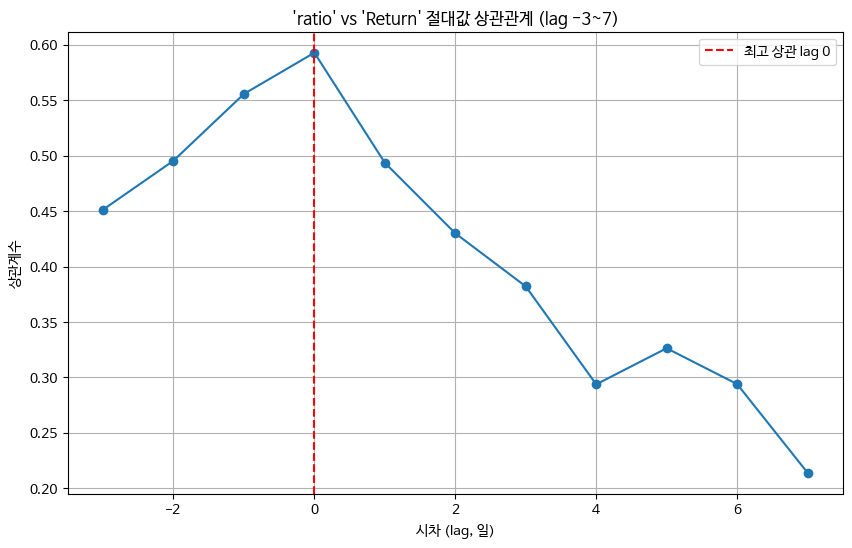

In [9]:
if __name__ == "__main__":
    # 네이버 API 키
    CLIENT_ID = "NjCkeE5n21b4IPWLlbAi"
    CLIENT_SECRET = "J6RWn6YJz8"

    # 네이버 데이터랩 트렌드 데이터 호출
    trend_df = fetch_naver_datalab_trends(
        CLIENT_ID, CLIENT_SECRET,
        keywords=["상지건설"],
        start_date="2024-06-23",
        end_date="2025-06-23"
    )

    # 주가 수익률 데이터 불러오기
    returns_df = get_daily_returns("042940", start_date="2024-06-21")

    # 감성 데이터와 주가 수익률 병합
    merged_df = merge_sentiment_and_returns(returns_df, trend_df)

    # 시차별 상관관계 분석 및 시각화
    lagged_correlation_analysis(merged_df, ratio_col='ratio', return_col='Return', date_col='날짜', min_lag=-3, max_lag=7)